# Imports

In [1]:
import pandas as pd
import yfinance as yf
import investpy as iv
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from ta.trend import MACD

import vectorbt as vbt
from vectorbt.portfolio import Orders

## Download Data

In [2]:
boi = pd.read_excel('/home/edilson07/projects/boi_gordo/data/boi_gordo.xlsx', index_col='Data').sort_index(ascending=True)
dolar = pd.read_excel('/home/edilson07/projects/boi_gordo/data/dolar_fut.xlsx', index_col='Data').sort_index(ascending=True)
di = pd.read_excel('/home/edilson07/projects/boi_gordo/data/di_fut.xlsx', index_col='Data').sort_index(ascending=True)
win = pd.read_excel('/home/edilson07/projects/boi_gordo/data/winfut.xlsx', index_col='Data').sort_index(ascending=True) 

In [3]:
gold = yf.download('GC=F', start='2003-01-02', end='2023-12-09')
t10 = yf.download('^TNX', start='2003-01-02', end='2023-12-09')
petroleo = yf.download('CL=F', start='2003-01-02', end='2023-12-09')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Feature Engineering

## Resample to Month

In [4]:
boi = boi.resample('W').last()

In [5]:
boi.head()

,Abertura,Máxima,Mínima,Fechamento
Data,,,,
2003-01-05,62.13,62.13,61.80,61.80
2003-01-12,61.53,61.53,60.60,60.66
2003-01-19,61.59,61.59,60.49,60.55
2003-01-26,61.15,61.24,61.15,61.20
2003-02-02,62.34,62.52,62.17,62.24


## Returns

In [6]:
boi['Return'] = boi['Fechamento'].pct_change()
gold['Return'] = gold['Adj Close'].pct_change()
dolar['Return'] = dolar['Fechamento'].pct_change()
t10['Return'] = t10['Adj Close'].pct_change()
di['Return'] = di['Fechamento'].pct_change()
win['Return'] = win['Fechamento'].pct_change()
petroleo['Return'] = petroleo['Adj Close'].pct_change()


## Inverter ordem das datas

In [7]:
boi.head()

,Abertura,Máxima,Mínima,Fechamento,Return
Data,,,,,
2003-01-05,62.13,62.13,61.80,61.80,NaN
2003-01-12,61.53,61.53,60.60,60.66,-0.018447
2003-01-19,61.59,61.59,60.49,60.55,-0.001813
2003-01-26,61.15,61.24,61.15,61.20,0.010735
2003-02-02,62.34,62.52,62.17,62.24,0.016993


## Indicadores

In [8]:
# Médias Móveis
boi['MediaMovelCurto'] = boi['Fechamento'].rolling(window=13).mean()
boi['MediaMovelMedio'] = boi['Fechamento'].rolling(window=50).mean()
boi['MediaMovelLongo'] = boi['Fechamento'].rolling(window=200).mean()

# Bandas de Bollinger
bb = BollingerBands(close=boi['Fechamento'], window=20, window_dev=2)
boi['Bollinger_H'] = bb.bollinger_hband()
boi['Bollinger_L'] = bb.bollinger_lband()

# RSI
rsi_ind = RSIIndicator(close=boi['Fechamento'])
boi['RSI'] = rsi_ind.rsi()

# MACD
macd_int = MACD(close=boi['Fechamento'])
boi['MACD_Line'] = macd_int.macd()
boi['MACD_Diff'] = macd_int.macd_diff()
boi['MACD_Signal'] = macd_int.macd_signal()


boi.dropna(inplace=True)

In [9]:
boi.head()

,Abertura,Máxima,Mínima,Fechamento,Return,MediaMovelCurto,MediaMovelMedio,MediaMovelLongo,Bollinger_H,Bollinger_L,RSI,MACD_Line,MACD_Diff,MACD_Signal
Data,,,,,,,,,,,,,,
2006-10-29,58.9,59.00,58.86,58.90,-0.008418,59.275385,52.5836,57.76905,65.826244,46.666756,58.232591,2.796790,0.330408,2.466382
2006-11-05,56.0,56.10,55.76,56.05,-0.048387,59.202308,52.6086,57.74030,65.598538,47.589462,49.561236,2.342535,-0.099077,2.441613
2006-11-12,53.5,54.25,53.50,54.25,-0.032114,59.060000,52.6144,57.70825,65.238351,48.479649,45.003211,1.816352,-0.500208,2.316561
2006-11-19,53.9,54.20,53.50,53.90,-0.006452,58.956923,52.6644,57.67500,64.990789,49.087211,44.152907,1.355482,-0.768863,2.124345
2006-11-26,52.3,52.70,52.01,52.65,-0.023191,58.691538,52.7394,57.63225,64.829836,49.433164,41.161674,0.879238,-0.996085,1.875324


## Sazonalidade

In [10]:
# Sazonalidade
#boi['Mes'] = boi.index.month
#boi['Estacao'] = boi.index.quarter

## Lag 1 one day

In [11]:
boi['Lagged_Close'] = boi['Fechamento'].shift(-2)

In [12]:
boi.head()

,Abertura,Máxima,Mínima,Fechamento,Return,MediaMovelCurto,MediaMovelMedio,MediaMovelLongo,Bollinger_H,Bollinger_L,RSI,MACD_Line,MACD_Diff,MACD_Signal,Lagged_Close
Data,,,,,,,,,,,,,,,
2006-10-29,58.9,59.00,58.86,58.90,-0.008418,59.275385,52.5836,57.76905,65.826244,46.666756,58.232591,2.796790,0.330408,2.466382,54.25
2006-11-05,56.0,56.10,55.76,56.05,-0.048387,59.202308,52.6086,57.74030,65.598538,47.589462,49.561236,2.342535,-0.099077,2.441613,53.90
2006-11-12,53.5,54.25,53.50,54.25,-0.032114,59.060000,52.6144,57.70825,65.238351,48.479649,45.003211,1.816352,-0.500208,2.316561,52.65
2006-11-19,53.9,54.20,53.50,53.90,-0.006452,58.956923,52.6644,57.67500,64.990789,49.087211,44.152907,1.355482,-0.768863,2.124345,52.60
2006-11-26,52.3,52.70,52.01,52.65,-0.023191,58.691538,52.7394,57.63225,64.829836,49.433164,41.161674,0.879238,-0.996085,1.875324,52.95


In [13]:
boi = boi.fillna(0)

In [14]:
boi.columns

Index(['Abertura', 'Máxima', 'Mínima', 'Fechamento', 'Return',
       'MediaMovelCurto', 'MediaMovelMedio', 'MediaMovelLongo', 'Bollinger_H',
       'Bollinger_L', 'RSI', 'MACD_Line', 'MACD_Diff', 'MACD_Signal',
       'Lagged_Close'],
      dtype='object')

## Pre-Processing

In [15]:
#pp_data = boi.drop(['Abertura','Máxima','Mínima'], axis=1)

In [16]:
#pp_data.columns

In [17]:
data = boi.copy()
cols_mms = ['Abertura', 'Máxima', 'Mínima', 'Return',
       'MediaMovelCurto', 'MediaMovelMedio', 'MediaMovelLongo', 'Bollinger_H',
       'Bollinger_L', 'RSI', 'MACD_Line', 'MACD_Diff', 'MACD_Signal']

mms = MinMaxScaler()

data[cols_mms] = mms.fit_transform(boi[cols_mms])

## Train-test Split

In [18]:
X = data.drop(['Lagged_Close','Fechamento', 'Abertura','Máxima','Mínima'], axis=1)
y = data[['Lagged_Close','Fechamento']]

mask_train = X.index < '2021-01-01'
mask_test = X.index >= '2021-01-01'


X_train = X[mask_train]
y_train = y.loc[mask_train,'Lagged_Close']

X_test = X[mask_test]
y_test = y.loc[mask_test, 'Fechamento']

## Linear Regression

In [19]:
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [20]:
print(f'MAE: {mean_absolute_error(y_pred, y_test)}')
print(f'MAPE: {mean_absolute_percentage_error(y_pred, y_test)}')
print(f'RMSE: {mean_squared_error(y_pred, y_test, squared=False)}')
print(f'MSE: {mean_squared_error(y_pred, y_test)}')

MAE: 6.712020264012055
MAPE: 0.022726908774401137
RMSE: 7.829443879151402
MSE: 61.300191456781356


In [21]:
y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=['Fechamento_Predito'])

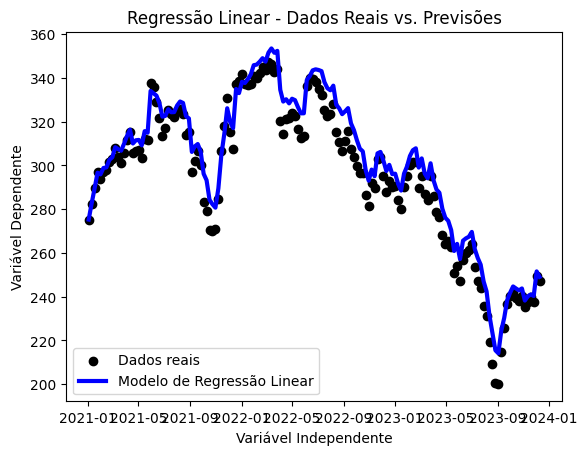

In [22]:
# Plote os resultados
plt.scatter(X_test.index, y_test, color='black', label='Dados reais')
plt.plot(X_test.index, y_pred, color='blue', linewidth=3, label='Modelo de Regressão Linear')
plt.title('Regressão Linear - Dados Reais vs. Previsões')
plt.xlabel('Variável Independente')
plt.ylabel('Variável Dependente')
plt.legend()
plt.show()

In [23]:
# Obtenha os coeficientes do modelo
coeficientes = lr.coef_
intercepto = lr.intercept_

# Imprima os coeficientes e o intercepto
print(f"Coeficientes: {coeficientes}")
print(f"Intercepto: {intercepto}")

# Imprima a equação da regressão linear
equacao_regressao = f"y = {intercepto:.2f} + {coeficientes[0]:.2f}x1 + {coeficientes[1]:.2f}x2 + ..."
print(f"Equação da Regressão Linear: {equacao_regressao}")

Coeficientes: [  15.0557473   345.77051225 -231.50802526  -15.62864707  119.02772074
   99.17724627    9.25203385  -21.58355048   68.99079255  -50.34405628]
Intercepto: 35.17863698866026
Equação da Regressão Linear: y = 35.18 + 15.06x1 + 345.77x2 + ...


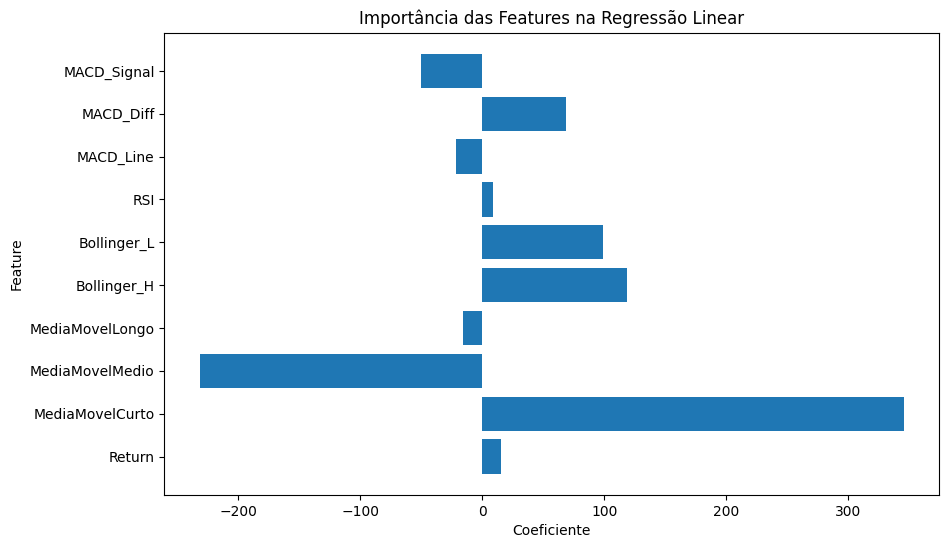

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Coeficientes do modelo de regressão linear
coeficientes = lr.coef_

# Nomes das features
nomes_features = X_train.columns

# Crie um gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(nomes_features, coeficientes)

# Adicione rótulos e título
plt.xlabel('Coeficiente')
plt.ylabel('Feature')
plt.title('Importância das Features na Regressão Linear')

# Exiba o gráfico
plt.show()


In [25]:
y_test

Data
2021-01-03    275.00
2021-01-10    282.30
2021-01-17    289.80
2021-01-24    297.20
2021-01-31    294.00
               ...  
2023-11-12    237.60
2023-11-19    239.75
2023-11-26    237.75
2023-12-03    249.60
2023-12-10    247.15
Freq: W-SUN, Name: Fechamento, Length: 154, dtype: float64

In [26]:
y_pred

,Fechamento_Predito
Data,
2021-01-03,275.250393
2021-01-10,282.620195
2021-01-17,289.492390
2021-01-24,296.678340
2021-01-31,295.914808
...,...
2023-11-12,240.150221
2023-11-19,241.031928
2023-11-26,240.319122


## Cross Validation

In [27]:
n_splits = 5

tscv = TimeSeriesSplit(n_splits=n_splits)

model = LinearRegression()

cv_results = cross_val_score(model, X[:-2], y['Lagged_Close'][:-2], cv=tscv, scoring='neg_mean_squared_error')

print("Resultados da validação cruzada:", cv_results)
print("Média dos resultados:", cv_results.mean())

Resultados da validação cruzada: [ -33.13834666   -6.75039143   -9.63954927 -142.88686345 -216.0408901 ]
Média dos resultados: -81.69120818203253


## Predict Everything

In [122]:
y_pred_full = lr.predict(X)

## Backtest

In [144]:
df_bt = boi.copy()

df_bt['Predicted'] = y_pred_full

# Converta o índice para o formato datetime se ainda não estiver
df_bt.index = pd.to_datetime(df_bt.index)

In [145]:
# Adicione uma coluna 'Signal' que representa os sinais de compra (+1), venda (-1), curta (-1) e cobertura (+1)

df_bt['Signal'] = 0  # inicializa todos os sinais como 0
df_bt.loc[df_bt['Signal'] == 0, 'Signal'] = np.where(df_bt['Predicted'] > df_bt['Fechamento'], 1, -1)
# Crie uma coluna 'Position' no DataFrame para armazenar as posições
df_bt['Position'] = 0
df_bt.dropna(inplace=True)        

In [148]:
# Implemente as regras do backtest
df_bt['Position'] = vbt.signals.first_choice(df_bt['Signals'], first_choice=1, choices=[-1, 0], wait=0)

# Execute o backtest
portfolio = vbt.Portfolio.from_signals(df_bt['Signals'], price=df_bt['Signals'], freq='d', cash_sharing=True)
portfolio = portfolio.apply_mask(df_bt['Position'].values)

# Resultados do backtest
print(portfolio.stats())

AttributeError: module 'vectorbt.signals' has no attribute 'first_choice'

TypeError: 'numpy.ndarray' object is not callable

In [37]:
y_pred

,Fechamento_Predito
Data,
2021-01-03,275.250393
2021-01-10,282.620195
2021-01-17,289.492390
2021-01-24,296.678340
2021-01-31,295.914808
...,...
2023-11-12,240.150221
2023-11-19,241.031928
2023-11-26,240.319122


/tmp/ipykernel_161133/675939732.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test[0]


275.0

## LASSO

In [277]:
lasso = Lasso(alpha=0.1)

lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)

/home/edilson07/.pyenv/versions/3.10.11/envs/boi_analise/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e+02, tolerance: 1.442e+02
  model = cd_fast.enet_coordinate_descent(


In [278]:
print(f'MAE: {mean_absolute_error(y_pred, y_test)}')
print(f'MAPE: {mean_absolute_percentage_error(y_pred, y_test)}')
print(f'RMSE: {mean_squared_error(y_pred, y_test, squared=False)}')
print(f'MSE: {mean_squared_error(y_pred, y_test)}')

MAE: 2.418982172606807
MAPE: 0.008314435348093011
RMSE: 2.8725217339462303
MSE: 8.251381111993458


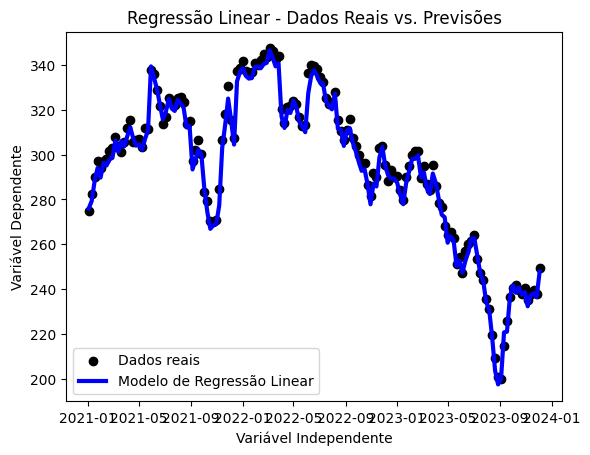

In [279]:
# Plote os resultados
plt.scatter(X_test.index, y_test, color='black', label='Dados reais')
plt.plot(X_test.index, y_pred, color='blue', linewidth=3, label='Modelo de Regressão Linear')
plt.title('Regressão Linear - Dados Reais vs. Previsões')
plt.xlabel('Variável Independente')
plt.ylabel('Variável Dependente')
plt.legend()
plt.show()

In [280]:
X

,Abertura,Máxima,Mínima,Return,MediaMovelCurto,MediaMovelMedio,MediaMovelLongo,Bollinger_H,Bollinger_L,RSI,MACD_Line,MACD_Diff,MACD_Signal
Data,,,,,,,,,,,,,
2006-10-29,0.026837,0.025941,0.027830,0.478425,0.022727,0.000000,0.007244,0.029607,0.000000,0.561917,0.540022,0.562276,0.537149
2006-11-05,0.017108,0.016234,0.017385,0.284115,0.022474,0.000092,0.007115,0.028887,0.003418,0.452705,0.529041,0.527609,0.536435
2006-11-12,0.008722,0.010042,0.009771,0.363225,0.021982,0.000113,0.006972,0.027749,0.006715,0.395299,0.516321,0.495231,0.532833
2006-11-19,0.010064,0.009874,0.009771,0.487982,0.021626,0.000297,0.006823,0.026967,0.008966,0.384590,0.505181,0.473546,0.527296
2006-11-26,0.004696,0.004854,0.004751,0.406604,0.020708,0.000572,0.006632,0.026458,0.010248,0.346916,0.493669,0.455206,0.520122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-05,0.610869,0.616736,0.614387,0.416148,0.599889,0.770416,0.994383,0.670892,0.564522,0.394381,0.297842,0.837367,0.150360
2023-11-12,0.628984,0.628285,0.629717,0.569998,0.604729,0.765562,0.995392,0.659836,0.568628,0.416531,0.316229,0.826132,0.176282
2023-11-19,0.630996,0.635314,0.629717,0.563337,0.612827,0.761487,0.996566,0.646059,0.575721,0.436203,0.336560,0.822337,0.201865


## Cross Validation

In [218]:
n_splits = 5

tscv = TimeSeriesSplit(n_splits=n_splits)

model = Lasso(alpha=0.5)

cv_results = cross_val_score(model, X, y['Lagged_Close'], cv=tscv, scoring='neg_mean_squared_error')

print("Resultados da validação cruzada:", cv_results)
print("Média dos resultados:", cv_results.mean())

Resultados da validação cruzada: [-1490.39985351  -690.16309099  -107.23062901  -363.29352517
  -508.90662708]
Média dos resultados: -631.998745152958


In [219]:
for train_index, test_index in tscv.split(X):
    print("Conjunto de treinamento:", train_index)
    print("Conjunto de teste:", test_index)
    print("----")

Conjunto de treinamento: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Conjunto de teste: [12 13 14 15 16 17 18 19]
----
Conjunto de treinamento: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Conjunto de teste: [20 21 22 23 24 25 26 27]
----
Conjunto de treinamento: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
Conjunto de teste: [28 29 30 31 32 33 34 35]
----
Conjunto de treinamento: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
Conjunto de teste: [36 37 38 39 40 41 42 43]
----
Conjunto de treinamento: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
Conjunto de teste: [44 45 46 47 48 49 50 51]
----


## Ridge

In [173]:
ridge = Ridge(alpha=0.75)

ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

In [174]:
print(f'MAE: {mean_absolute_error(y_pred, y_test)}')
print(f'MAPE: {mean_absolute_percentage_error(y_pred, y_test)}')
print(f'RMSE: {mean_squared_error(y_pred, y_test, squared=False)}')
print(f'MSE: {mean_squared_error(y_pred, y_test)}')

MAE: 7.364678791539189
MAPE: 0.0264313220717868
RMSE: 10.125024319301286
MSE: 102.51611746644247


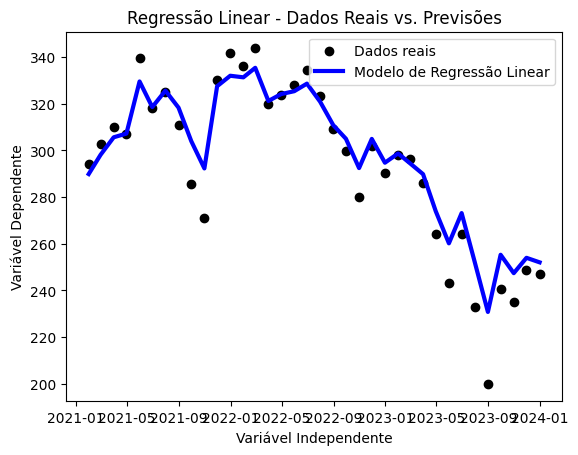

In [175]:
# Plote os resultados
plt.scatter(X_test.index, y_test, color='black', label='Dados reais')
plt.plot(X_test.index, y_pred, color='blue', linewidth=3, label='Modelo de Regressão Linear')
plt.title('Regressão Linear - Dados Reais vs. Previsões')
plt.xlabel('Variável Independente')
plt.ylabel('Variável Dependente')
plt.legend()
plt.show()

## XGBoost

In [115]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

In [116]:
print(f'MAE: {mean_absolute_error(y_pred, y_test)}')
print(f'MAPE: {mean_absolute_percentage_error(y_pred, y_test)}')
print(f'RMSE: {mean_squared_error(y_pred, y_test, squared=False)}')
print(f'MSE: {mean_squared_error(y_pred, y_test)}')

MAE: 22.50781877305773
MAPE: 0.0790463743941158
RMSE: 26.66354639539489
MSE: 710.9447063793758


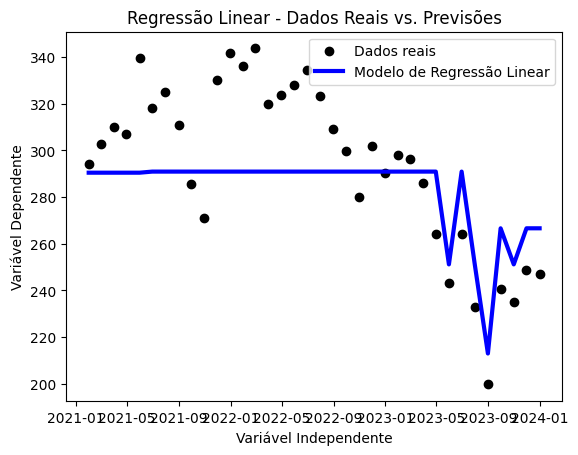

In [117]:
# Plote os resultados
plt.scatter(X_test.index, y_test, color='black', label='Dados reais')
plt.plot(X_test.index, y_pred, color='blue', linewidth=3, label='Modelo de Regressão Linear')
plt.title('Regressão Linear - Dados Reais vs. Previsões')
plt.xlabel('Variável Independente')
plt.ylabel('Variável Dependente')
plt.legend()
plt.show()

In [118]:
y_test

Data
2021-01-31    294.00
2021-02-28    302.90
2021-03-31    309.90
2021-04-30    306.90
2021-05-31    339.50
2021-06-30    318.00
2021-07-31    325.10
2021-08-31    310.80
2021-09-30    285.65
2021-10-31    271.00
2021-11-30    330.25
2021-12-31    341.90
2022-01-31    336.00
2022-02-28    343.70
2022-03-31    320.05
2022-04-30    323.85
2022-05-31    328.00
2022-06-30    334.60
2022-07-31    323.45
2022-08-31    309.20
2022-09-30    299.70
2022-10-31    280.20
2022-11-30    301.90
2022-12-31    290.40
2023-01-31    298.20
2023-02-28    296.30
2023-03-31    286.10
2023-04-30    264.20
2023-05-31    243.05
2023-06-30    264.20
2023-07-31    232.80
2023-08-31    199.65
2023-09-30    240.50
2023-10-31    235.10
2023-11-30    248.90
2023-12-31    247.15
Freq: M, Name: Fechamento, dtype: float64

In [119]:
y_pred

array([290.42252, 290.42252, 290.42252, 290.42252, 290.42252, 290.89093,
       290.89117, 290.89075, 290.89075, 290.89075, 290.89075, 290.89075,
       290.89075, 290.89075, 290.89075, 290.89075, 290.89075, 290.89075,
       290.89075, 290.89075, 290.89075, 290.89075, 290.89075, 290.89075,
       290.89075, 290.89075, 290.89075, 290.89075, 251.11418, 290.89075,
       251.11418, 212.91093, 266.5829 , 251.11418, 266.5829 , 266.5829 ],
      dtype=float32)

In [120]:
X_test

,Abertura,Máxima,Mínima,Return,MediaMovelCurto,MediaMovelMedio,MediaMovelLongo,Bollinger_H,Bollinger_L,RSI,MACD_Line,MACD_Diff,MACD_Signal
Data,,,,,,,,,,,,,
2021-01-31,0.713543,0.726901,0.715385,0.585788,0.481148,0.188945,0.247482,0.663571,0.037925,0.894353,0.855411,0.989709,0.732583
2021-02-28,0.762244,0.776233,0.768956,0.478266,0.530124,0.213224,0.269263,0.722251,0.049935,0.917336,0.895371,0.994040,0.780579
2021-03-31,0.807114,0.813573,0.808242,0.458428,0.578685,0.239994,0.291688,0.775699,0.074966,0.934711,0.929764,0.986316,0.827611
2021-04-30,0.797811,0.801036,0.802198,0.367603,0.633848,0.266335,0.313783,0.813675,0.118776,0.900512,0.944797,0.941220,0.869010
2021-05-31,0.977565,0.986100,0.972802,0.688639,0.700996,0.299080,0.339002,0.875846,0.150937,0.976799,0.996493,0.978840,0.915107
2021-06-30,0.871683,0.879259,0.863462,0.219007,0.754365,0.328008,0.361985,0.908653,0.198547,0.774708,0.997298,0.906639,0.952188
2021-07-31,0.907798,0.911965,0.899176,0.456259,0.804559,0.358555,0.385569,0.952263,0.212375,0.796254,1.000000,0.852689,0.982530
2021-08-31,0.836389,0.840556,0.824725,0.272581,0.844839,0.388118,0.408090,0.973428,0.256459,0.675572,0.972897,0.749617,1.000000
2021-09-30,0.722845,0.720360,0.681593,0.170281,0.865727,0.412040,0.428709,0.973449,0.313048,0.496027,0.906903,0.588981,0.997408
